<a href="https://colab.research.google.com/github/cxbxmxcx/Practical_AI_on_GCP/blob/master/Chapter_4_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

In [2]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteVXASL0/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteVXASL0/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteVXASL0/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [3]:
encoder = info.features['text'].encoder
encoder.subwords[2000:2010]

['Cha',
 'sco',
 'represent',
 'portrayed_',
 'outs',
 'dri',
 'crap_',
 'Oh',
 'word_',
 'open_']

In [4]:
padded_shapes = ([None],())
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes = padded_shapes)

train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[  69,   81,    9, ...,    0,    0,    0],
       [5970,   37, 2456, ...,    7,  666, 7970],
       [ 134,   55,    1, ...,    0,    0,    0],
       ...,
       [  12,   18,  357, ...,    0,    0,    0],
       [  12, 3059, 5086, ...,    0,    0,    0],
       [2756, 6656, 1263, ...,    0,    0,    0]])

In [5]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, validation_steps=20)

Epoch 1/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.5151 - accuracy: 0.7517 - val_loss: 0.3691 - val_accuracy: 0.8750
Epoch 2/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.2845 - accuracy: 0.8941 - val_loss: 0.3624 - val_accuracy: 0.8650
Epoch 3/10
2500/2500 [==============================] - 22s 9ms/step - loss: 0.2302 - accuracy: 0.9172 - val_loss: 0.3076 - val_accuracy: 0.8950
Epoch 4/10
2500/2500 [==============================] - 23s 9ms/step - loss: 0.1978 - accuracy: 0.9300 - val_loss: 0.4044 - val_accuracy: 0.8550
Epoch 5/10
2500/2500 [==============================] - 23s 9ms/step - loss: 0.1756 - accuracy: 0.9368 - val_loss: 0.4215 - val_accuracy: 0.8600
Epoch 6/10
2500/2500 [==============================] - 22s 9ms/step - loss: 0.1588 - accuracy: 0.9452 - val_loss: 0.4752 - val_accuracy: 0.8450
Epoch 7/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.1428 - accuracy: 0.9510 - val_loss: 0.3831 - val_ac

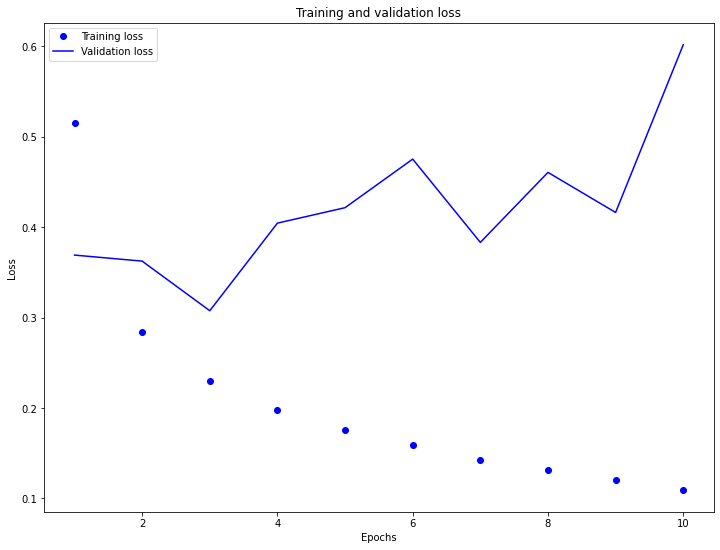

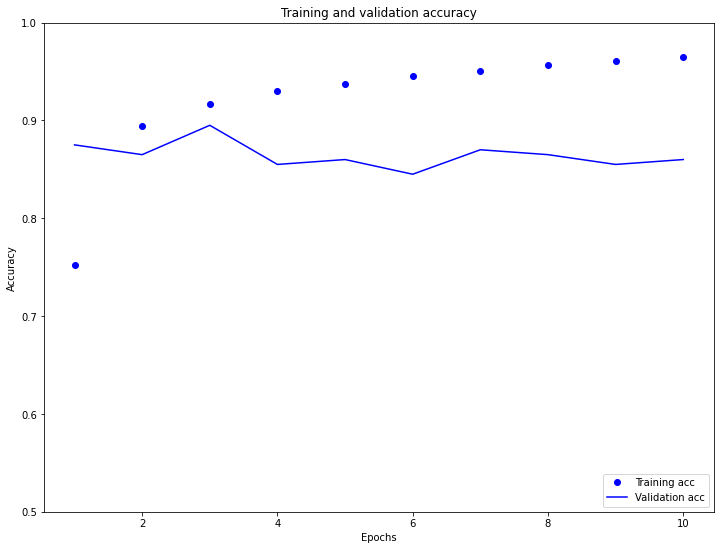

In [7]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

In [8]:
e = model.layers[0]
weights = e.get_weights()[0]

import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

In [9]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>